In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from os import walk
from os.path import join

plt.style.use('seaborn')
%matplotlib inline

pbp_dir = 'Play By Play Data'

# Get a list of all the files in the top level of a directory
def fileList(directory):
    f = []
    for (dirpath, dirnames, filenames) in walk(directory):
        f.extend(filenames)
        break
    
    return f

# Compile all CSV files from a directory into a single dataframe
def dfFromDirectory(directory):
    pbplist = fileList(directory)
    pbp_df = pd.DataFrame()
    for f in pbplist:
        if f[-3:].upper() == 'CSV':
            df = pd.read_csv(join(directory, f))
            pbp_df = pbp_df.append(df, ignore_index=True)
        
    return pbp_df

# Filter the Play By Play dataframe by event. Context = True will include the 2 plays before and after the event
def filterByEvent(pbp_df, e1, e2 = -1, context = False):
    if e2 > -1:
        idx_list = pbp_df.index[(pbp_df['EVENTMSGTYPE'] == e1) & (pbp_df['EVENTMSGACTIONTYPE'] == e2)].tolist()
    else:
        idx_list = pbp_df.index[pbp_df['EVENTMSGTYPE'] == e1].tolist()
    if context:
        filter_idx = []
        for idx in idx_list:
            filter_idx.extend([idx-2, idx-1, idx, idx+1, idx+2])
    else:
        filter_idx = idx_list
    play_df = pbp_df.iloc[filter_idx]
    
    return play_df

In [2]:
pbp_df = dfFromDirectory(pbp_dir) # Compile dataframe from CSV files in directory
all_reb_df = filterByEvent(pbp_df, 4, 0) # Get all player rebounds

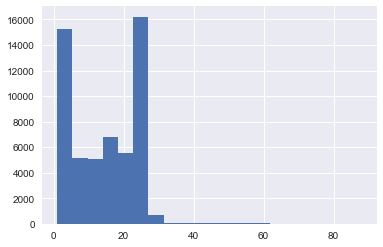

In [3]:
# Extract the shot distance from the description fields
def shot_distance(row):
    if int(row['EVENTMSGTYPE']) == 2: # Missed Field Goal
        if int(row['PERSON1TYPE']) == 4: # Home team
            try:
                dist = int(re.findall("(\d+)\'", row['HOMEDESCRIPTION'])[0]) # Get all digits immediately preceding '
            except:
                dist = None
        if int(row['PERSON1TYPE']) == 5: # Visitor team
            try:
                dist = int(re.findall("(\d+)\'", row['VISITORDESCRIPTION'])[0]) # Get all digits immediately preceding '
            except:
                dist = None
        return dist

# Get the distance of the shot preceding the rebound
def addShotDistToRebounds(row):
    if row['EVENTMSGTYPE'] == 2:
        return shot_distance(row)
    if pbp_df.iloc[row.name-1]['EVENTMSGTYPE'] == 2: # If previous event was a missed FG
        return shot_distance(pbp_df.iloc[row.name-1])

# Get the ID of the player who took the shot preceding the rebound
def addShooterID(row):
    prevrow = pbp_df.iloc[row.name-1]
    if ((prevrow['EVENTMSGTYPE'] == 2) and
       (row['EVENTMSGTYPE'] == 4) and
       (row['EVENTMSGACTIONTYPE'] == 0)): # If player rebound is preceded by missed FG
        return str(prevrow['PLAYER1_ID'])
    
# Determine if the team that shot the ball got the rebound
def addOffensiveRebounds(row):
    prevrow = pbp_df.iloc[row.name-1]
    if ((prevrow['EVENTMSGTYPE'] == 2) and
       (row['EVENTMSGTYPE'] == 4) and
       (row['EVENTMSGACTIONTYPE'] == 0)): # If player rebound is preceded by missed FG
        if (((prevrow['PERSON1TYPE'] == 4) and (row['PERSON1TYPE'] == 4)) or
           ((prevrow['PERSON1TYPE'] == 5) and (row['PERSON1TYPE'] == 5))): # Same team shot and got the rebound
            return True
        else:
            return False

# Determine if the shot preceding the rebound was blocked
def addBlock(row):
    prevrow = pbp_df.iloc[row.name-1]
    if (prevrow['EVENTMSGTYPE'] == 2) and (row['EVENTMSGTYPE'] == 4) and (row['EVENTMSGACTIONTYPE'] == 0): # If player rebound is preceded by missed FG
        if ('BLOCK' in str(prevrow['HOMEDESCRIPTION'])) or ('BLOCK' in str(prevrow['VISITORDESCRIPTION'])): # Same team shot and got the rebound
            return True
        else:
            return False
        
# Combine all of these functions into one function to use for apply
def addShotInfo(row):
    row['SHOT_DISTANCE'] = addShotDistToRebounds(row)
    row['SHOOTER_ID'] = addShooterID(row)
    row['OFFENSIVE_REB'] = addOffensiveRebounds(row)
    row['BLOCKED_SHOT'] = addBlock(row)
    return row

# Add new columns
all_reb_df = all_reb_df.apply(addShotInfo, axis=1)

all_reb_df['SHOT_DISTANCE'].hist(bins = 20)

In [4]:
print("{} total player rebounds".format(
    len(all_reb_df),
    len(all_reb_df[all_reb_df['OFFENSIVE_REB'] == True]),
    len(all_reb_df[all_reb_df['OFFENSIVE_REB'] == False])
    ))

print("{} of them were immediately preceded by a missed field goal ({} offensive, {} defensive)".format(
    all_reb_df['BLOCKED_SHOT'].value_counts().sum(),
    len(all_reb_df[all_reb_df['OFFENSIVE_REB'] == True]),
    len(all_reb_df[all_reb_df['OFFENSIVE_REB'] == False])
    ))

print("Of those {} rebounds, {} were from blocked shots, {} were not".format(
    all_reb_df['BLOCKED_SHOT'].value_counts().sum(),
    all_reb_df['BLOCKED_SHOT'].value_counts()[True],
    all_reb_df['BLOCKED_SHOT'].value_counts()[False]
    ))

62253 total player rebounds
58531 of them were immediately preceded by a missed field goal (12901 offensive, 45630 defensive)
Of those 58531 rebounds, 6190 were from blocked shots, 52341 were not


In [5]:
missfg_reb_df = all_reb_df[all_reb_df['BLOCKED_SHOT'] == False]
missfg_reb_df.to_csv('REBS_MissedFG.csv')